<a href="https://colab.research.google.com/github/kamilwyszynski/gnn_training_set_reduction_testing/blob/main/GNN_training_set_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

### Installations

In [ ]:
!pip install --upgrade pip
!pip install torch-geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch_sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

     |████████████████████████████████| 1.5MB 13.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 186 kB 17.2 MB/s 
     |████████████████████████████████| 2.2 MB 14.5 MB/s 
     |████████████████████████████████| 231 kB 46.5 MB/s 
     |████████████████████████████████| 45 kB 4.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-py3-none-any.whl size=322718 sha256=8cf5d3345810a49a24dc43bb43ef4fb64de160c0a97b441b29af2a50c4cc3c8b
  Stored in directory: /root/.cache/pip/wheels/55/be/05/a068e58b901163f619e69824868d3ca17171b1482446f585d8
Successfully built torch-geometric
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 11.9 MB 5.5 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 24.3 MB 31 kB/s 
Looking in links: https:/

### Modules

In [ ]:
import torch_geometric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
%matplotlib inline
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 150})'''))

<IPython.core.display.Javascript object>

### Helper functions

* `print_dataset_details` - 
* `get_base_prediction_rate` - 
* `train` - One-pass train function
* `test` - Test function
* `train_epochs` - Train process function that displays loss and accuracy info
* `test_accuracy_distribution` - Function printing out the prediction accuracy accross different classes
* `get_reduced_train_dataset` - Get a dataset with reduced train mask
* `get_trained_gcn_model` - Create, train and return a model
* `visualize` - Graph visualisation
* `perform_test_series` - Perform an entire test set

In [ ]:
def print_dataset_details(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

    data = dataset[0]  # Get the first graph object.

    print()
    print(data)
    print('===========================================================================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def get_base_prediction_rate(data):
    largest_class = max([np.sum(data.y.numpy() == i) for i in data.y.unique().numpy()])
    return round(largest_class / len(data.y), 3)

def train(model, data, optimizer, criterion):
  model.train()
  optimizer.zero_grad()  # Clear gradients.
  out = model(data.x, data.edge_index)  # Perform a single forward pass.
  loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss

def test(model, data):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

def train_epochs(model, data, optimizer, criterion, epochs=100, checkpoints=[]):
  for epoch in range(1, epochs+1):
    loss = train(model, data, optimizer, criterion)

    if epoch in checkpoints:
      acc = test(model, data)
      print(f'Epoch: {epoch:03d}\n\tLoss: {loss:.4f}\n\tAccuracy: {100*acc:.2f}\n')

def test_accuracy_distribution(model, data, print_details=False):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    correct_classes = data.y[data.test_mask]
    predicted_classes = pred[data.test_mask]

    test_correct = predicted_classes == correct_classes
    correctly_predicted_classes = correct_classes[test_correct] # Get only correctly predicted

    correctly_predicted = []
    accuracy = []

    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
    if print_details:
        print('Test classes:')
    for c in data.y.unique().numpy():
        num_of_correct_nodes = (correctly_predicted_classes==c).sum()
        num_of_test_nodes = (correct_classes==c).sum()
        num_of_nodes = (data.y==c).sum()
        if print:
            print(f'\nClass {c}: \
            \n\tCorrect nodes: {num_of_correct_nodes}\
            \n\tTest nodes: {num_of_test_nodes}\
            \n\tTest representation: {100*num_of_test_nodes/num_of_nodes:.2f}%\
            \n\tAccuracy: {100*num_of_correct_nodes/num_of_test_nodes:.2f}%')

        accuracy.append(float(100*num_of_correct_nodes/num_of_test_nodes))
        correctly_predicted.append(int(num_of_correct_nodes))

    return accuracy, correctly_predicted

def get_reduced_train_dataset(dataset, train_size):
    data = dataset[0]
    train_classes = data.y[data.train_mask].numpy()

    if (type(train_size) == float) & (train_size == 1):
        return data

    # Create a stratified sample of the default train set
    train_idx, _ = train_test_split(np.arange(len(train_classes)),
                                    train_size=train_size,
                                    stratify=train_classes)

    new_train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    new_train_mask[train_idx] = True
    data.train_mask = new_train_mask

    # print(f'Number of new train nodes: {int(new_train_mask.sum())}')

    return data

def get_trained_gcn_model(dataset, train_size=1.0, hidden_channels=16):
    # Get training data
    data = get_reduced_train_dataset(dataset, train_size)

    # Create model, opt and crit
    model = GCN(hidden_channels=16, dataset=dataset)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # train model
    train_epochs(model, data, optimizer, criterion, epochs=200)

    return model

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def perform_test_series(dataset, train_sizes):
    models = {}
    accuracies = {}
    class_accuracies = {}
    correct_predtions = {}
    number_of_training_nodes = {}

    # train and test models
    for i, train_size in enumerate(train_sizes, start=1):
        # Getting data here only to count the number of training nodes
        # There's probably a better way to do this
        data = get_reduced_train_dataset(dataset, train_size)

        model = get_trained_gcn_model(dataset, train_size)
        acc, corr = test_accuracy_distribution(model, dataset[0])

        models[f'Test {i}'] = model
        accuracies[f'Test {i}'] = test(model, dataset[0])
        class_accuracies[f'Test {i}'] = acc
        correct_predtions[f'Test {i}'] = corr
        number_of_training_nodes[f'Test {i}'] = int(data.train_mask.sum())

    # compose dataframes
    accuracy = pd.DataFrame({'Number of training nodes': number_of_training_nodes.values(),
                             'Accuracy (%)':accuracies.values()},
                            # columns=['Number of training nodes', 'Accuracy (%)'],
                            index=accuracies.keys())
    accuracy['Accuracy change (%)'] = accuracy['Accuracy (%)'].pct_change() * 100

    class_accuracy = pd.DataFrame(class_accuracies).T
    correct_predtion = pd.DataFrame(correct_predtions).T
    
    return {'accuracy': accuracy,
            'class_accuracy': class_accuracy, 
            'correct_predtion': correct_predtion,
            'models': models}

### GCN model

* Create a simple, reusable GCN model class

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dataset):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Cora Dataset

### Dataset setup

* Get the Cora dataset
* Print out useful insights into the dataset

In [ ]:
cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print_dataset_details(cora)


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


### Train mask discovery

* Gather useful insights about the dafault training mask

In [ ]:
data = cora[0]
default_training_mask = data.train_mask # Boolean Tensor
train_indices = default_training_mask.nonzero().flatten() # First 140 indices are train nodes

In [ ]:
train_classes = data.y[train_indices]

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
print('Training classes:')
for c in train_classes.unique():
    num_of_train_nodes = (train_classes==c).sum()
    num_of_nodes = (data.y==c).sum()
    print(f'\nClass {c}: \
    \n\tTrain nodes: {num_of_train_nodes}\
    \n\tOverall nodes: {num_of_nodes}\
    \n\tTraining representation: {100*num_of_train_nodes/num_of_nodes:.2f}%')

<IPython.core.display.Javascript object>

Training classes:

Class 0:     
	Train nodes: 20    
	Overall nodes: 351    
	Training representation: 5.70%

Class 1:     
	Train nodes: 20    
	Overall nodes: 217    
	Training representation: 9.22%

Class 2:     
	Train nodes: 20    
	Overall nodes: 418    
	Training representation: 4.78%

Class 3:     
	Train nodes: 20    
	Overall nodes: 818    
	Training representation: 2.44%

Class 4:     
	Train nodes: 20    
	Overall nodes: 426    
	Training representation: 4.69%

Class 5:     
	Train nodes: 20    
	Overall nodes: 298    
	Training representation: 6.71%

Class 6:     
	Train nodes: 20    
	Overall nodes: 180    
	Training representation: 11.11%


### Base prediction rate

This is an estimation of what is the lowest plausible accuracy for a specified datased 

In [ ]:
get_base_prediction_rate(cora[0])

0.302

### Training set reduction

* Training the GCN model on the Cora dataset training masks with the following sizes:
    * __Test 1__: The default training mask
    * __Test 2__: 75% of the default training mask
    * __Test 3__: 50% of the default training mask
    * __Test 4__: 25% of the default training mask
    * __Test 5__: 28 nodes
    * __Test 6__: 21 nodes
    * __Test 7__: 14 nodes
    * __Test 8__: 7 nodes (Smallest mask possible)

In [ ]:
# There is an error when going below 7 (which is the number of classes)
train_sizes = [1.0, 0.75, 0.5, 0.25] + [28, 21, 14, 7]
outcome = perform_test_series(dataset, train_sizes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Test outcome analysis

**Accuray over different tests**

Visiblyon the two graphs below, the default training set can be reduced to 50% and even 25% of its original size (Test 1 size: 140, Test 3 size: 70, Test 4 size: 35) while still performing with a near intact accuracy (Test 1: 81.4%, Test 3: 77.5%, Test 4: 75.6%). 
<br>
<br>
<br>


..._That's only about 5% decrease in accuracy!_

In [ ]:
outcome['accuracy']['Accuracy change (%)'] = outcome['accuracy']['Accuracy (%)'].pct_change() * 100

In [ ]:
outcome['accuracy']

,Number of training nodes,Accuracy (%),Accuracy change (%)
Test 1,140,0.814,NaN
Test 2,105,0.782,-3.931204
Test 3,70,0.764,-2.301790
Test 4,35,0.756,-1.047120
Test 5,28,0.681,-9.920635
Test 6,21,0.628,-7.782673
Test 7,14,0.447,-28.821656
Test 8,7,0.272,-39.149888


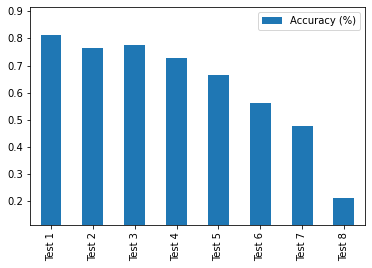

In [ ]:
ymax = outcome['accuracy']['Accuracy (%)'].max()+0.1
ymin = outcome['accuracy']['Accuracy (%)'].min()-0.1
outcome['accuracy'].plot(y='Accuracy (%)',kind='bar',ylim=(ymin, ymax))

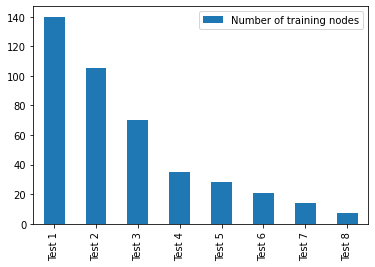

In [ ]:
outcome['accuracy'].plot(y='Number of training nodes',kind='bar')

In [ ]:
outcome

{'accuracy':         Number of training nodes  Accuracy (%)  Accuracy change (%)
 Test 1                       140         0.814                  NaN
 Test 2                       105         0.782            -3.931204
 Test 3                        70         0.764            -2.301790
 Test 4                        35         0.756            -1.047120
 Test 5                        28         0.681            -9.920635
 Test 6                        21         0.628            -7.782673
 Test 7                        14         0.447           -28.821656
 Test 8                         7         0.272           -39.149888,
 'class_accuracy':                 0          1          2  ...          4          5        6
 Test 1  76.923080  85.714287  88.888885  ...  87.919464  78.640778  78.1250
 Test 2  83.076920  86.813187  88.888885  ...  79.865768  76.699028  62.5000
 Test 3  75.384613  84.615387  88.888885  ...  87.248322  66.019417  76.5625
 Test 4  67.692307  82.417580  87.500000

### Attempt to better sample a default train set

* Creating a custom training mask (using stratified sampling) containing 100% nodes of the default training mask

##### Prepare dataset

In [ ]:
data_test_5 = dataset[0]

all_classes = data_test_5.y.numpy()
new_train_indices, _ = train_test_split(np.arange(len(all_classes)),
                                        train_size=140,
                                        stratify=all_classes)

new_train_mask = torch.zeros(data_test_5.num_nodes, dtype=torch.bool)
new_train_mask[new_train_indices] = True
data_test_5.train_mask = new_train_mask

print(f'Number of new train nodes: {int(new_train_mask.sum())}')

Number of new train nodes: 140


##### Create and train the model

In [ ]:
model_test_5 = GCN(hidden_channels=16, dataset=dataset)
optimizer_test_5 = torch.optim.Adam(model_test_5.parameters(), lr=0.01, weight_decay=5e-4)
criterion_test_5 = torch.nn.CrossEntropyLoss()

train_epochs(model_test_5, data_test_5, optimizer_test_5, criterion_test_5, 200, [50, 100, 150, 200])

Epoch: 050
	Loss: 1.2531
	Accuracy: 55.80

Epoch: 100
	Loss: 0.7701
	Accuracy: 75.00

Epoch: 150
	Loss: 0.6066
	Accuracy: 79.70

Epoch: 200
	Loss: 0.4286
	Accuracy: 82.00



##### Conclusion

* The accuracy of a model trained on this training dataset is actually lower than the default training dataset, therefore I'm assuming it's not worth exploring

In [ ]:
test_5_accuracy, test_5_correctly_predicted = test_accuracy_distribution(model_test_5, data_test_5)

<IPython.core.display.Javascript object>

Test classes:

Class 0:         
	Correct nodes: 102        
	Test nodes: 130        
	Test representation: 37.04%        
	Accuracy: 78.46%

Class 1:         
	Correct nodes: 63        
	Test nodes: 91        
	Test representation: 41.94%        
	Accuracy: 69.23%

Class 2:         
	Correct nodes: 130        
	Test nodes: 144        
	Test representation: 34.45%        
	Accuracy: 90.28%

Class 3:         
	Correct nodes: 283        
	Test nodes: 319        
	Test representation: 39.00%        
	Accuracy: 88.71%

Class 4:         
	Correct nodes: 118        
	Test nodes: 149        
	Test representation: 34.98%        
	Accuracy: 79.19%

Class 5:         
	Correct nodes: 80        
	Test nodes: 103        
	Test representation: 34.56%        
	Accuracy: 77.67%

Class 6:         
	Correct nodes: 34        
	Test nodes: 64        
	Test representation: 35.56%        
	Accuracy: 53.12%


# Pubmed Dataset

PubMed dataset, while similar to the Cora dataset used before is quite larger.
The dataset contains more than 19 000 node in it's graph (Comparing with about 2500 in Cora). Another difference betwwen the dataset is the amount of node classes; PubMed has 3 while Cora has 7.


<br>


It's similarities and differences with Cora makes the PubMed dataset a good candidate to perform further analysis on.

### Dataset setup

* Get thedataset
* Print out useful insights into the dataset

In [ ]:
pubmed = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
print_dataset_details(pubmed)

Processing...
Done!

Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


### Base prediction rate

This is an estimation of what is the lowest plausible accuracy for a specified datased 

In [ ]:
get_base_prediction_rate(pubmed[0])

0.399

### Training set reduction

* Training the GCN model on the Cora dataset training masks with the following sizes:
    * __Test 1__: The default training mask
    * __Test 2__: 75% of the default training mask
    * __Test 3__: 50% of the default training mask
    * __Test 4__: 25% of the default training mask
    * __Test 5__: 9 nodes
    * __Test 6__: 6 nodes
    * __Test 7__: 3 nodes (Smallest mask possible)

In [ ]:
train_sizes = [1.0, 0.75, 0.5, 0.25] + [9, 6, 3]
outcome = perform_test_series(pubmed, train_sizes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

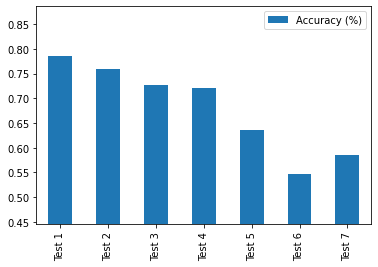

In [ ]:
ymax = outcome['accuracy']['Accuracy (%)'].max()+0.1
ymin = outcome['accuracy']['Accuracy (%)'].min()-0.1
outcome['accuracy'].plot(y='Accuracy (%)',kind='bar',ylim=(ymin, ymax))

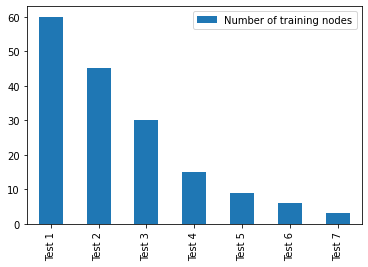

In [ ]:
outcome['accuracy'].plot(y='Number of training nodes',kind='bar')

In [ ]:
outcome

{'accuracy':         Number of training nodes  Accuracy (%)  Accuracy change (%)
 Test 1                        60         0.786                  NaN
 Test 2                        45         0.760            -3.307888
 Test 3                        30         0.727            -4.342105
 Test 4                        15         0.720            -0.962861
 Test 5                         9         0.636           -11.666667
 Test 6                         6         0.546           -14.150943
 Test 7                         3         0.585             7.142857,
 'class_accuracy':                 0          1          2
 Test 1  78.333336  82.324455  74.938576
 Test 2  78.888885  80.387405  70.270271
 Test 3  83.888885  67.312347  73.218674
 Test 4  81.111115  75.302666  64.619164
 Test 5  92.777779  69.491524  44.717445
 Test 6  76.666664  55.205811  44.226044
 Test 7  57.777779  69.975784  47.174446,
 'correct_predtion':           0    1    2
 Test 1  141  340  305
 Test 2  142  332  286

# CiteSeer Dataset

### Dataset setup

* Get the dataset
* Print out useful insights into the dataset

In [ ]:
citeseer = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
print_dataset_details(citeseer)

Processing...
Done!

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(edge_index=[2, 9104], test_mask=[3327], train_mask=[3327], val_mask=[3327], x=[3327, 3703], y=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


### Base prediction rate

This is an estimation of what is the lowest plausible accuracy for a specified datased 

In [ ]:
citeseer_base = get_base_prediction_rate(citeseer[0])
citeseer_base

0.211

### Training set reduction

* Training the GCN model on the Cora dataset training masks with the following sizes:
    * __Test 1__: The default training mask
    * __Test 2__: 75% of the default training mask
    * __Test 3__: 50% of the default training mask
    * __Test 4__: 25% of the default training mask
    * __Test 5__: 24 nodes
    * __Test 6__: 18 nodes
    * __Test 6__: 12 nodes
    * __Test 7__: 6 nodes (Smallest mask possible)

In [ ]:
train_sizes = [1.0, 0.75, 0.5, 0.25] + [24, 18, 12, 6]
outcome = perform_test_series(citeseer, train_sizes)

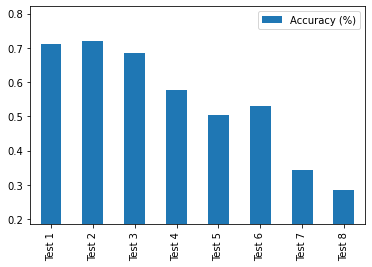

In [ ]:
ymax = outcome['accuracy']['Accuracy (%)'].max()+0.1
ymin = outcome['accuracy']['Accuracy (%)'].min()-0.1
outcome['accuracy'].plot(y='Accuracy (%)',kind='bar',ylim=(ymin, ymax))

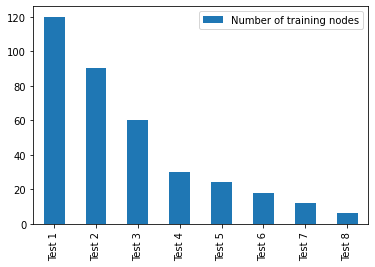

In [ ]:
outcome['accuracy'].plot(y='Number of training nodes',kind='bar')

In [ ]:
outcome

{'accuracy':         Number of training nodes  Accuracy (%)  Accuracy change (%)
 Test 1                       120         0.712                  NaN
 Test 2                        90         0.721             1.264045
 Test 3                        60         0.684            -5.131761
 Test 4                        30         0.578           -15.497076
 Test 5                        24         0.505           -12.629758
 Test 6                        18         0.531             5.148515
 Test 7                        12         0.342           -35.593220
 Test 8                         6         0.286           -16.374269,
 'class_accuracy':                 0          1          2          3          4       5
 Test 1  32.467533  62.087914  75.690605  73.593071  79.881660  82.500
 Test 2  36.363636  68.131866  74.585632  73.160172  84.023666  76.875
 Test 3  29.870131  58.791210  77.348068  70.995674  79.881660  71.875
 Test 4  23.376623  27.472527  46.961327  78.787880  86.982246  

-1
0
1
2
3
4
5
